<p style="font-family:'Century Gothic', sans-serif; font-size:150%; text-align:center; color:steelblue;">
    Visión por computadora | Proyecto Detección Placas de Vehiculos | YoloV10
</p>


In [1]:
!nvidia-smi

Sat Oct 19 07:56:13 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.90                 Driver Version: 565.90         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 Ti   WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   33C    P8             12W /  160W |     356MiB /   8188MiB |     21%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Descripción del Dataset

El dataset consta de un total de **737 imágenes** categorizadas en dos clases: `licence` y `licenseplate`. La distribución de las imágenes es la siguiente:

- **Conjunto de Entrenamiento**: 535 imágenes (73%)
- **Conjunto de Validación**: 138 imágenes (18%)
- **Conjunto de Prueba**: 66 imágenes (9%)

## Objetivo del Proyecto

El objetivo de este proyecto es **identificar** y **extraer los números** de las placas de los vehículos.


<div style="text-align: left;">
    <table>
        <tr>
            <th><b>Website dataset</b></th>
            <th><b>Links</b></th>
        </tr>
        <tr>
            <td>Roboflow</td>
            <td><a href="https://universe.roboflow.com/image-processing-u647q/vehicle-detection-639on/dataset/7"><img src="https://img.shields.io/badge/Roboflow-Dataset-blue?style=for-the-badge&logo=roboflow" alt="Roboflow"/></a></td>
        </tr>
    </table>
</div>


## Librerias

In [2]:
import cv2 #Cargar y manipular imagenes 
import os
import urllib.request
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import json
from ultralytics import YOLOv10  # Assuming your custom YOLOv10 import is valid
import numpy as np
import math
import re
from datetime import datetime
from paddleocr import PaddleOCR

c:\Users\danie\miniconda3\envs\yolov10_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


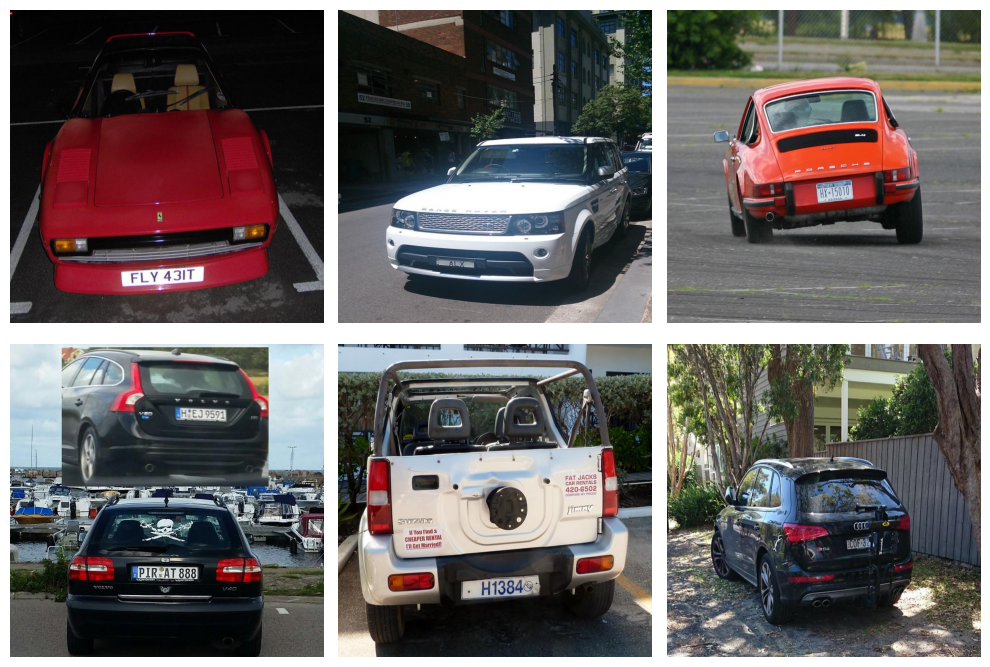

In [3]:
# Ruta de la carpeta con las imágenes
image_folder = r"C:\Users\danie\OneDrive\Documentos\ComputerVision\Project\yolov10\dataset\test\images"

# Obtener una lista de las imágenes en la carpeta
image_files = [f for f in os.listdir(image_folder) if f.endswith(('.png', '.jpg', '.jpeg'))]

# Seleccionar las primeras 6 imágenes
selected_images = image_files[:6]

# Crear el figplot 2x3
fig, axes = plt.subplots(2, 3, figsize=(10, 7))

# Iterar sobre las imágenes y mostrarlas en el grid
for i, ax in enumerate(axes.flat):
    # Cargar la imagen
    img_path = os.path.join(image_folder, selected_images[i])
    img = mpimg.imread(img_path)
    
    # Mostrar la imagen
    ax.imshow(img)
    ax.axis('off')  # Ocultar los ejes

# Ajustar el espaciado
plt.tight_layout()
plt.show()

## Preprocesamiento 

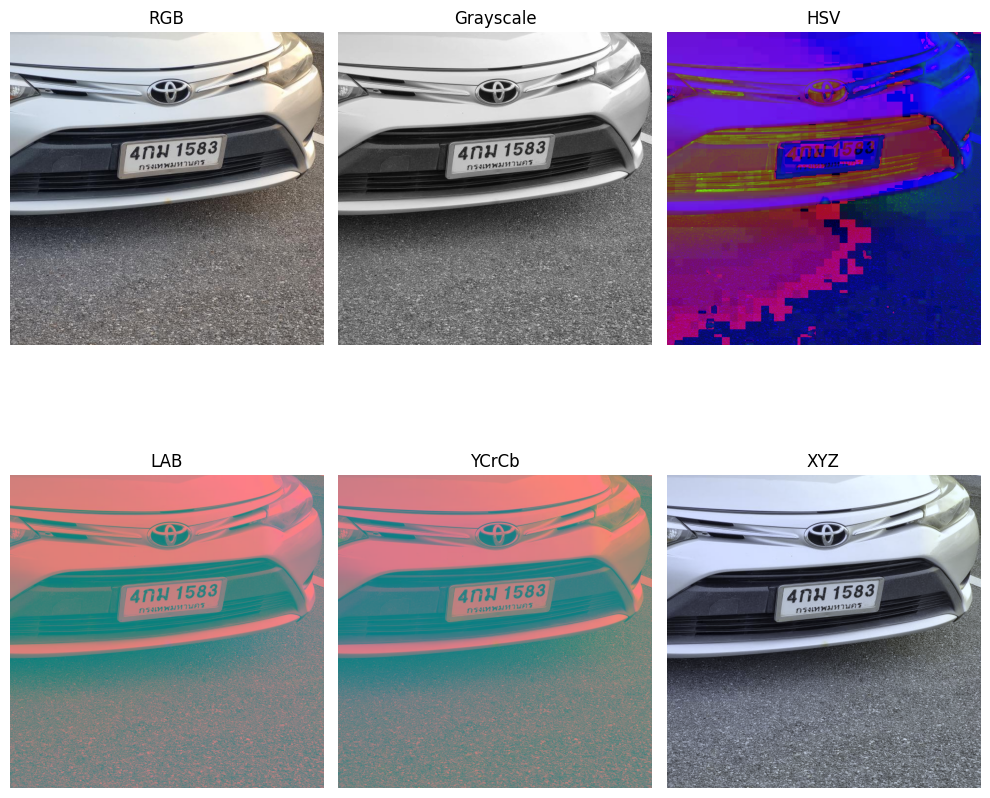

In [4]:
def show_color_spaces(input_image):
    plt.figure(figsize=(10, 10))

    # Original RGB image
    plt.subplot(2, 3, 1)
    plt.imshow(cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB))
    plt.title("RGB")
    plt.axis("off")
    # Convert to Grayscale
    gray = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)
    plt.subplot(2, 3, 2)
    plt.imshow(gray, cmap='gray')
    plt.title("Grayscale")
    plt.axis("off")
    # Convert to HSV
    hsv = cv2.cvtColor(input_image, cv2.COLOR_BGR2HSV)
    plt.subplot(2, 3, 3)
    plt.imshow(hsv)
    plt.title("HSV")
    plt.axis("off")
    # Convert to LAB
    lab = cv2.cvtColor(input_image, cv2.COLOR_BGR2LAB)
    plt.subplot(2, 3, 4)
    plt.imshow(lab)
    plt.title("LAB")
    plt.axis("off")
    # Convert to YCrCb
    ycrcb = cv2.cvtColor(input_image, cv2.COLOR_BGR2YCrCb)
    plt.subplot(2, 3, 5)
    plt.imshow(ycrcb)
    plt.title("YCrCb")
    plt.axis("off")
    # Convert to XYZ
    xyz = cv2.cvtColor(input_image, cv2.COLOR_BGR2XYZ)
    plt.subplot(2, 3, 6)
    plt.imshow(xyz)
    plt.title("XYZ")
    plt.axis("off")
    
    # Show the plots
    plt.tight_layout()
    plt.show()

# Ruta de la imagen
image_path = r"C:\Users\danie\OneDrive\Documentos\ComputerVision\Project\yolov10\dataset\train\images\20221128_172804_jpg.rf.b46def78c10b23918b485d37a27ff250.jpg"

# Leer la imagen
input_image = cv2.imread(image_path)

# Mostrar los espacios de color
show_color_spaces(input_image)

El espacio de color XYZ parece ser el que muestra la placa con mayor claridad por lo que se trabajara con ese.

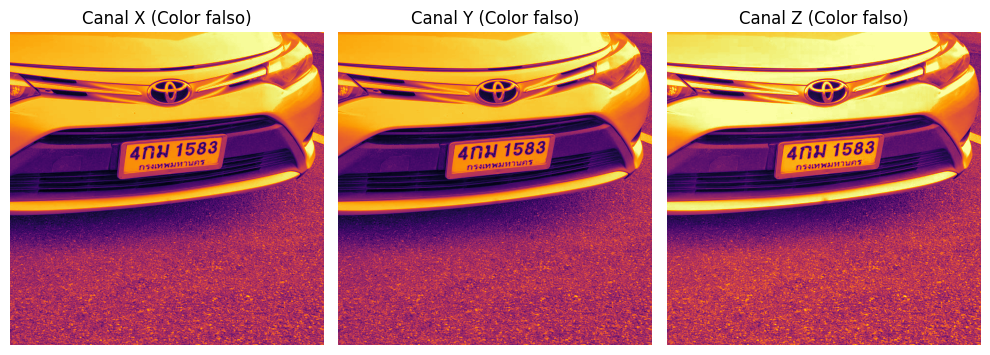

In [6]:
def show_xyz_channels_color(input_image):
    # Convertir la imagen al espacio de color XYZ
    xyz = cv2.cvtColor(input_image, cv2.COLOR_BGR2XYZ)
    
    # Separar los canales X, Y y Z
    X, Y, Z = cv2.split(xyz)
    
    # Normalizar los canales para que ocupen el rango completo [0, 255] y sean visibles
    X_norm = cv2.normalize(X, None, 0, 255, cv2.NORM_MINMAX)
    Y_norm = cv2.normalize(Y, None, 0, 255, cv2.NORM_MINMAX)
    Z_norm = cv2.normalize(Z, None, 0, 255, cv2.NORM_MINMAX)
    
    # Mostrar los canales con un mapa de color (color falso)
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(X_norm, cmap='inferno')
    plt.title("Canal X (Color falso)")
    plt.axis("off")
    
    plt.subplot(1, 3, 2)
    plt.imshow(Y_norm, cmap='inferno')
    plt.title("Canal Y (Color falso)")
    plt.axis("off")
    
    plt.subplot(1, 3, 3)
    plt.imshow(Z_norm, cmap='inferno')
    plt.title("Canal Z (Color falso)")
    plt.axis("off")
    
    # Mostrar la figura
    plt.tight_layout()
    plt.show()


# Mostrar los canales X, Y y Z con color falso
show_xyz_channels_color(input_image)


Cambiamos el espacio de color de todas las imagenes a canal xyz y nos quedamos con el canal Z para el procesamientro del modelo.

In [7]:
# Función para procesar una imagen, convertirla a XYZ y extraer el canal Z
def process_image_xyz_to_z(image_path):
    # Leer la imagen
    image = cv2.imread(image_path)
    
    # Convertir la imagen al espacio de color XYZ
    xyz = cv2.cvtColor(image, cv2.COLOR_BGR2XYZ)
    
    # Separar el canal Z
    _, _, Z = cv2.split(xyz)
    
    # Normalizar el canal Z al rango [0, 255] para guardarlo como imagen
    Z_normalized = cv2.normalize(Z, None, 0, 255, cv2.NORM_MINMAX)
    
    # Guardar la nueva imagen en el mismo path, reemplazando la original
    cv2.imwrite(image_path, Z_normalized)

# Función para procesar todas las imágenes en una carpeta, con mensajes de progreso
def process_folder(folder_path):
    # Obtener la lista de archivos de imagen en la carpeta
    images = [f for f in os.listdir(folder_path) if f.endswith(".jpg") or f.endswith(".png")]
    total_images = len(images)
    
    print(f"Procesando carpeta: {folder_path}")
    print(f"Total de imágenes a procesar: {total_images}")
    
    # Procesar cada imagen en la carpeta
    for idx, filename in enumerate(images):
        image_path = os.path.join(folder_path, filename)
        process_image_xyz_to_z(image_path)
        print(f"Procesadas {idx + 1} de {total_images} imágenes en {folder_path}")
    
    print(f"Procesamiento completado en carpeta: {folder_path}")

# Directorios de las imágenes
train_images_path = r"C:\Users\danie\OneDrive\Documentos\ComputerVision\Project2\train\images"
test_images_path = r"C:\Users\danie\OneDrive\Documentos\ComputerVision\Project2\test\images"
valid_images_path = r"C:\Users\danie\OneDrive\Documentos\ComputerVision\Project2\valid\images"

# Procesar las imágenes en cada carpeta
process_folder(train_images_path)
process_folder(test_images_path)
process_folder(valid_images_path)

print("Procesamiento total completado.")



Procesando carpeta: C:\Users\danie\OneDrive\Documentos\ComputerVision\Project2\train\images
Total de imágenes a procesar: 534
Procesadas 1 de 534 imágenes en C:\Users\danie\OneDrive\Documentos\ComputerVision\Project2\train\images
Procesadas 2 de 534 imágenes en C:\Users\danie\OneDrive\Documentos\ComputerVision\Project2\train\images
Procesadas 3 de 534 imágenes en C:\Users\danie\OneDrive\Documentos\ComputerVision\Project2\train\images
Procesadas 4 de 534 imágenes en C:\Users\danie\OneDrive\Documentos\ComputerVision\Project2\train\images
Procesadas 5 de 534 imágenes en C:\Users\danie\OneDrive\Documentos\ComputerVision\Project2\train\images
Procesadas 6 de 534 imágenes en C:\Users\danie\OneDrive\Documentos\ComputerVision\Project2\train\images
Procesadas 7 de 534 imágenes en C:\Users\danie\OneDrive\Documentos\ComputerVision\Project2\train\images
Procesadas 8 de 534 imágenes en C:\Users\danie\OneDrive\Documentos\ComputerVision\Project2\train\images
Procesadas 9 de 534 imágenes en C:\Users\d

## Importación de modelo YoloV10

In [9]:
!git clone https://github.com/THU-MIG/yolov10.git

Cloning into 'yolov10'...


In [3]:
%cd yolov10

c:\Users\danie\OneDrive\Documentos\ComputerVision\Project2\yolov10


In [13]:
!pip install . 

Processing c:\users\danie\onedrive\documentos\computervision\project2\yolov10
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached thop-0.1.1.post2209072238-py3-none-any.whl.metadata (2.7 kB)
Using cached thop-0.1.1.post2209072238-py3-none-any.whl (15 kB)
  Created wheel for ultralytics: filename=ultralytics-8.1.34-py3-none-any.whl size=735426 sha256=4c8dd2c34a75bb7d03b6e7dec5590852ea7a467a57d851ba6efef961510864fd
  Stored in directory: C:\Users\danie\AppData\Local\Temp\pip-ephem-wheel-cache-ifm1uf1m\wheels\57\8d\85\c711a404b939a7c494801abd38676394cbf3f60b92f0f6fa9e
Successfully built ultralytics
  Attempting uninstall: ultralytics
    Found existing installation: ultralytics 8.3.13
    Uninstalling

In [14]:
# Creamos un directorio para almacenar los pesos preentrenados de YoloV10
weights_dir = os.path.join(os.getcwd(), "weights")
os.makedirs(weights_dir, exist_ok=True)

# Enlaces de los pesos preentrenados se almacenan en una lista
urls = [
    "https://github.com/jameslahm/yolov10/releases/download/v1.0/yolov10n.pt",
    "https://github.com/jameslahm/yolov10/releases/download/v1.0/yolov10s.pt",
    "https://github.com/jameslahm/yolov10/releases/download/v1.0/yolov10m.pt",
    "https://github.com/jameslahm/yolov10/releases/download/v1.0/yolov10b.pt",
    "https://github.com/jameslahm/yolov10/releases/download/v1.0/yolov10x.pt",
]

# Descargamos cada archivo con un for loop
for url in urls:
    file_name = os.path.join(weights_dir, os.path.basename(url))
    urllib.request.urlretrieve(url, file_name)
    print(f"Downloaded {file_name}")

Downloaded c:\Users\danie\OneDrive\Documentos\ComputerVision\Project2\yolov10\weights\yolov10n.pt
Downloaded c:\Users\danie\OneDrive\Documentos\ComputerVision\Project2\yolov10\weights\yolov10s.pt
Downloaded c:\Users\danie\OneDrive\Documentos\ComputerVision\Project2\yolov10\weights\yolov10m.pt
Downloaded c:\Users\danie\OneDrive\Documentos\ComputerVision\Project2\yolov10\weights\yolov10b.pt
Downloaded c:\Users\danie\OneDrive\Documentos\ComputerVision\Project2\yolov10\weights\yolov10x.pt


Entrenamiento de modelo YoloV10

1) **task=detect**: Define la tarea como detección de objetos.  

2) **mode=train**: Especifica que haremos entrenamiento.  

3) **epochs=10000**: Establece el número de épocas de entrenamiento (iteraciones completas sobre el conjunto de datos) en 10,000.  

4) **batch=16**: Define el tamaño del lote, es decir, cuántas imágenes se procesan simultáneamente durante el entrenamiento.  

5) **plots=True**: Genera gráficos y visualizaciones del proceso de entrenamiento.  

6) **model=weights/yolov10n.pt**: Especifica el archivo de pesos preentrenados que se usará como punto de partida para el entrenamiento.  

7) **data=data.yaml**: Define el archivo de configuración `data.yaml`, que contiene información sobre las rutas de los datos y las clases a detectar.


In [15]:
!yolo task=detect mode=train epochs=100 batch=16 plots=True model=weights/yolov10n.pt data=data.yaml

New https://pypi.org/project/ultralytics/8.3.17 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.10.15 torch-2.4.1+cpu CPU (12th Gen Intel Core(TM) i5-12400)
engine\trainer: task=detect, mode=train, model=weights/yolov10n.pt, data=data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, sho

C:\Users\danie\miniconda3\envs\yolov10_env\lib\site-packages\ultralytics\nn\tasks.py:733: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(file, map_location=

1) **yolo task=detect**: Define la tarea como detección de objetos.  

2) **mode=predict**: Especifica que haremos predicción para realizar inferencias en imágenes o videos.  

3) **conf=0.25**: Establece el umbral de confianza en 0.25, mostrando solo las detecciones con una confianza mayor o igual al 25%.  

4) **save=True**: Guarda las imágenes con las predicciones realizadas, incluyendo los cuadros delimitadores.  

5) **model=runs/detect/train2/weights/best.pt**: Especifica el archivo de pesos preentrenados a utilizar para la predicción, en este caso, los mejores pesos obtenidos durante el entrenamiento.  

6) **source=car.jpg**: Define la imagen `car.jpg` como la fuente sobre la cual se realizará la predicción.

Predicciones con modelo entrenado.

In [5]:
!yolo task=detect mode=predict conf=0.25 save=True model=runs/detect/train/weights/best.pt source=car.jpg

Ultralytics YOLOv8.1.34 🚀 Python-3.10.15 torch-2.4.1+cpu CPU (12th Gen Intel Core(TM) i5-12400)
YOLOv10n summary (fused): 285 layers, 2695196 parameters, 0 gradients, 8.2 GFLOPs

image 1/1 c:\Users\danie\OneDrive\Documentos\ComputerVision\Project2\yolov10\car.jpg: 640x640 (no detections), 135.1ms
Speed: 3.5ms preprocess, 135.1ms inference, 7.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


C:\Users\danie\miniconda3\envs\yolov10_env\lib\site-packages\ultralytics\nn\tasks.py:733: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(file, map_location=

Resultados

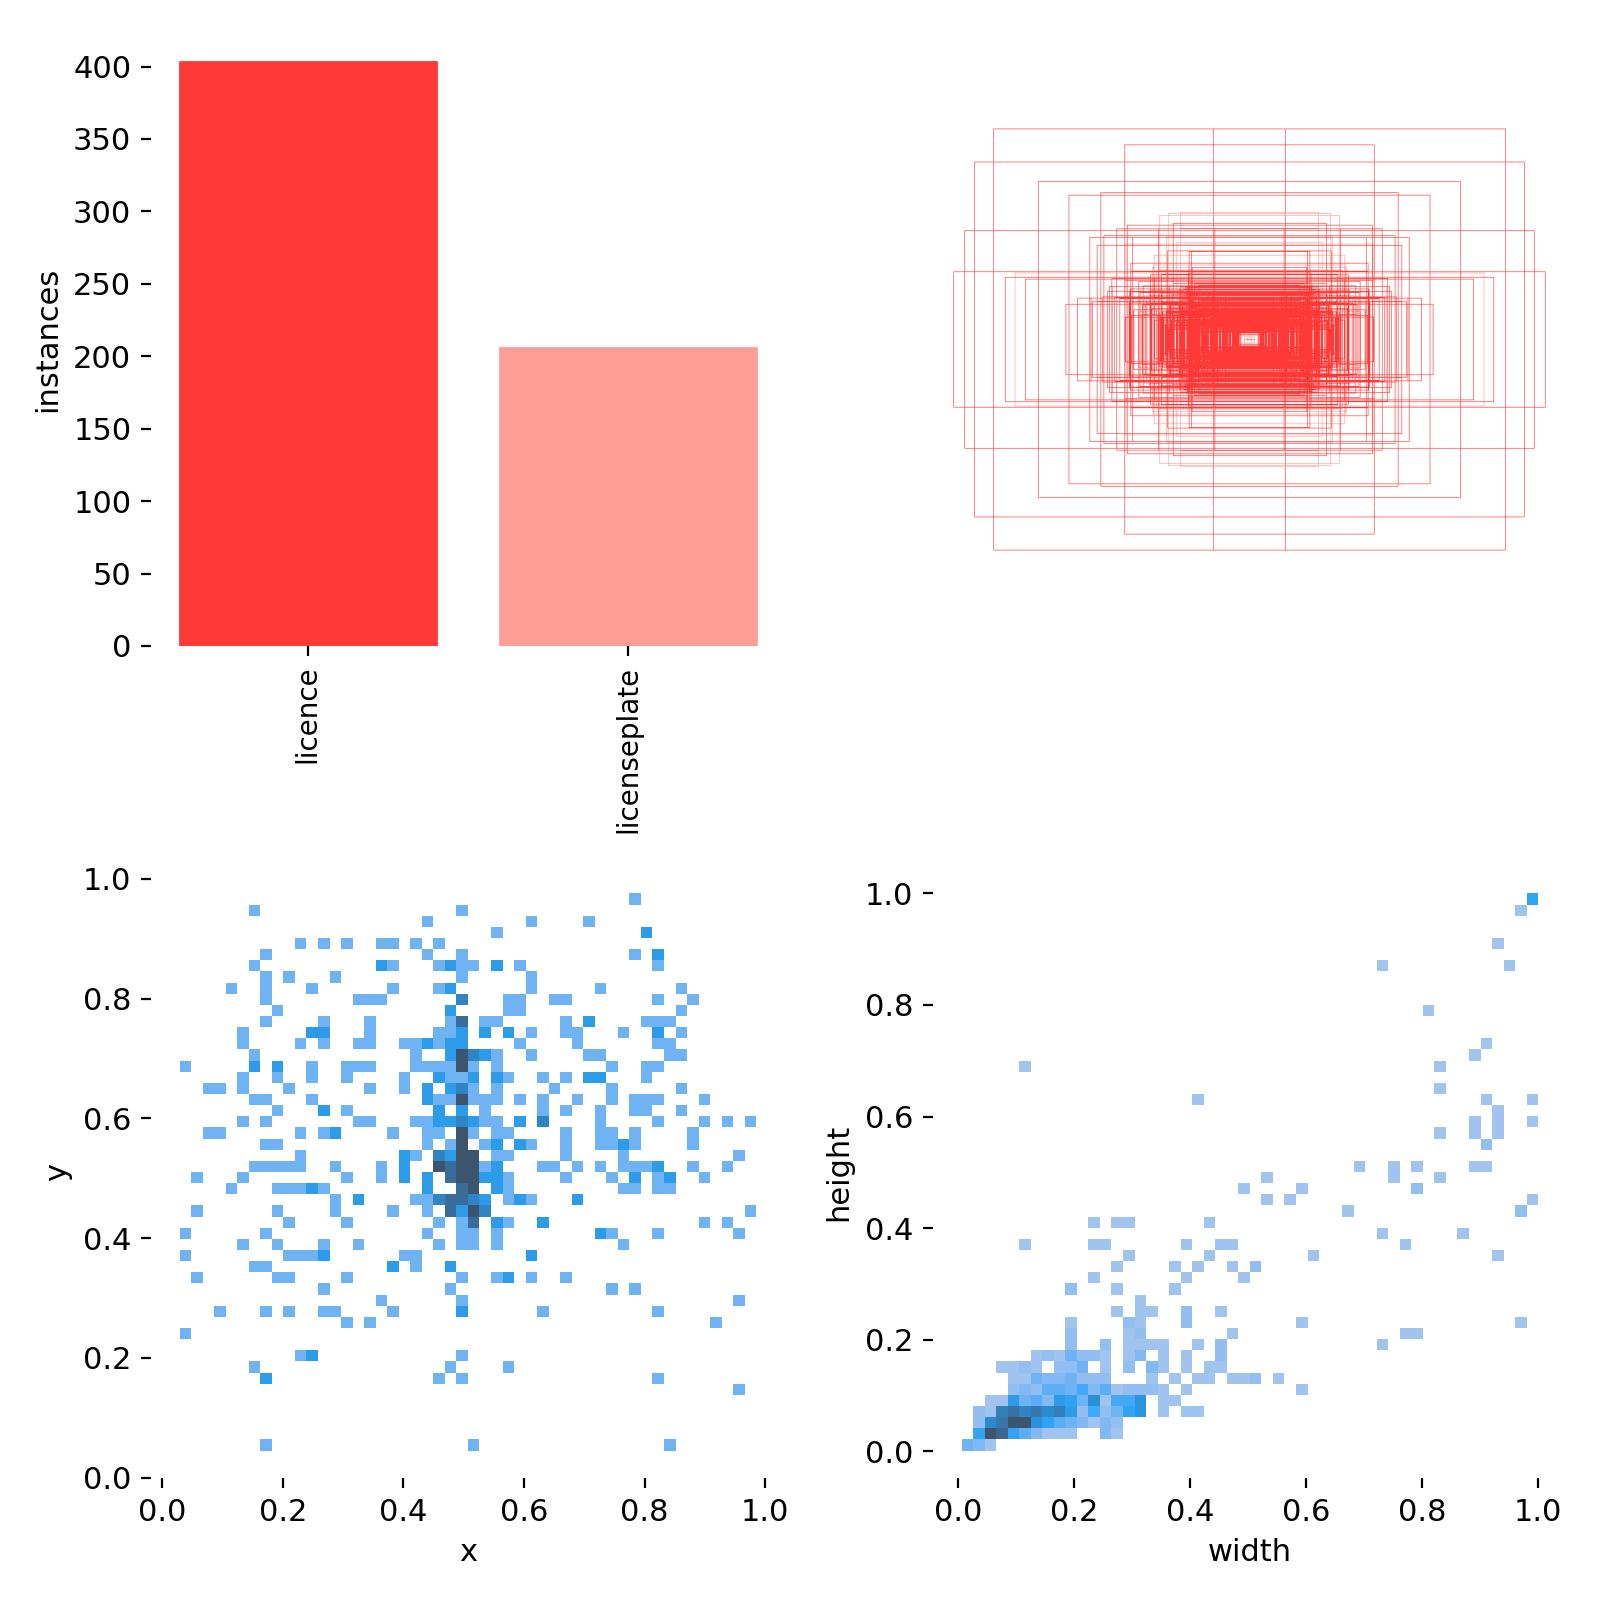

In [6]:
# Mostrar la imagen con un tamaño ajustado
display(Image(filename=r"C:\Users\danie\OneDrive\Documentos\ComputerVision\Project2\yolov10\runs\detect\train\labels.jpg", width=800, height=800))

### Gráfico superior izquierdo (barras):
- **Qué representa**: Este gráfico de barras muestra la cantidad de instancias detectadas para cada una de las dos clases: `licence` y `licenseplate`.  
- La clase `licence` tiene alrededor de 400 instancias detectadas, mientras que la clase `licenseplate` tiene alrededor de 200 instancias.

### Gráfico superior derecho (cuadros delimitadores):
- **Qué representa**: Este gráfico muestra una superposición de todos los cuadros delimitadores (bounding boxes) predichos para los objetos detectados en la imagen.  
- La concentración de los cuadros rojos en una zona específica indica que la mayoría de los objetos detectados están en una región común de las imágenes, sugiriendo que el modelo está identificando patrones similares en las posiciones de los objetos.

### Gráfico inferior izquierdo (distribución de coordenadas `x` y `y`):
- **Qué representa**: Este gráfico muestra la distribución de las posiciones `x` e `y` de los objetos detectados en las imágenes, donde `x` es la coordenada horizontal y `y` es la coordenada vertical.  
- La mayoría de las detecciones están centradas en el gráfico, lo que sugiere que los objetos tienden a estar localizados alrededor del centro de las imágenes.

### Gráfico inferior derecho (ancho y alto de los cuadros delimitadores):
- **Qué representa**: Este gráfico muestra la relación entre el ancho y el alto de los cuadros delimitadores predichos para los objetos detectados.  
- La concentración de puntos en las esquinas inferiores indica que la mayoría de los cuadros delimitadores tienen un tamaño relativamente pequeño (pequeño ancho y alto), pero hay algunas detecciones con tamaños más grandes que se dispersan hacia áreas superiores del gráfico.


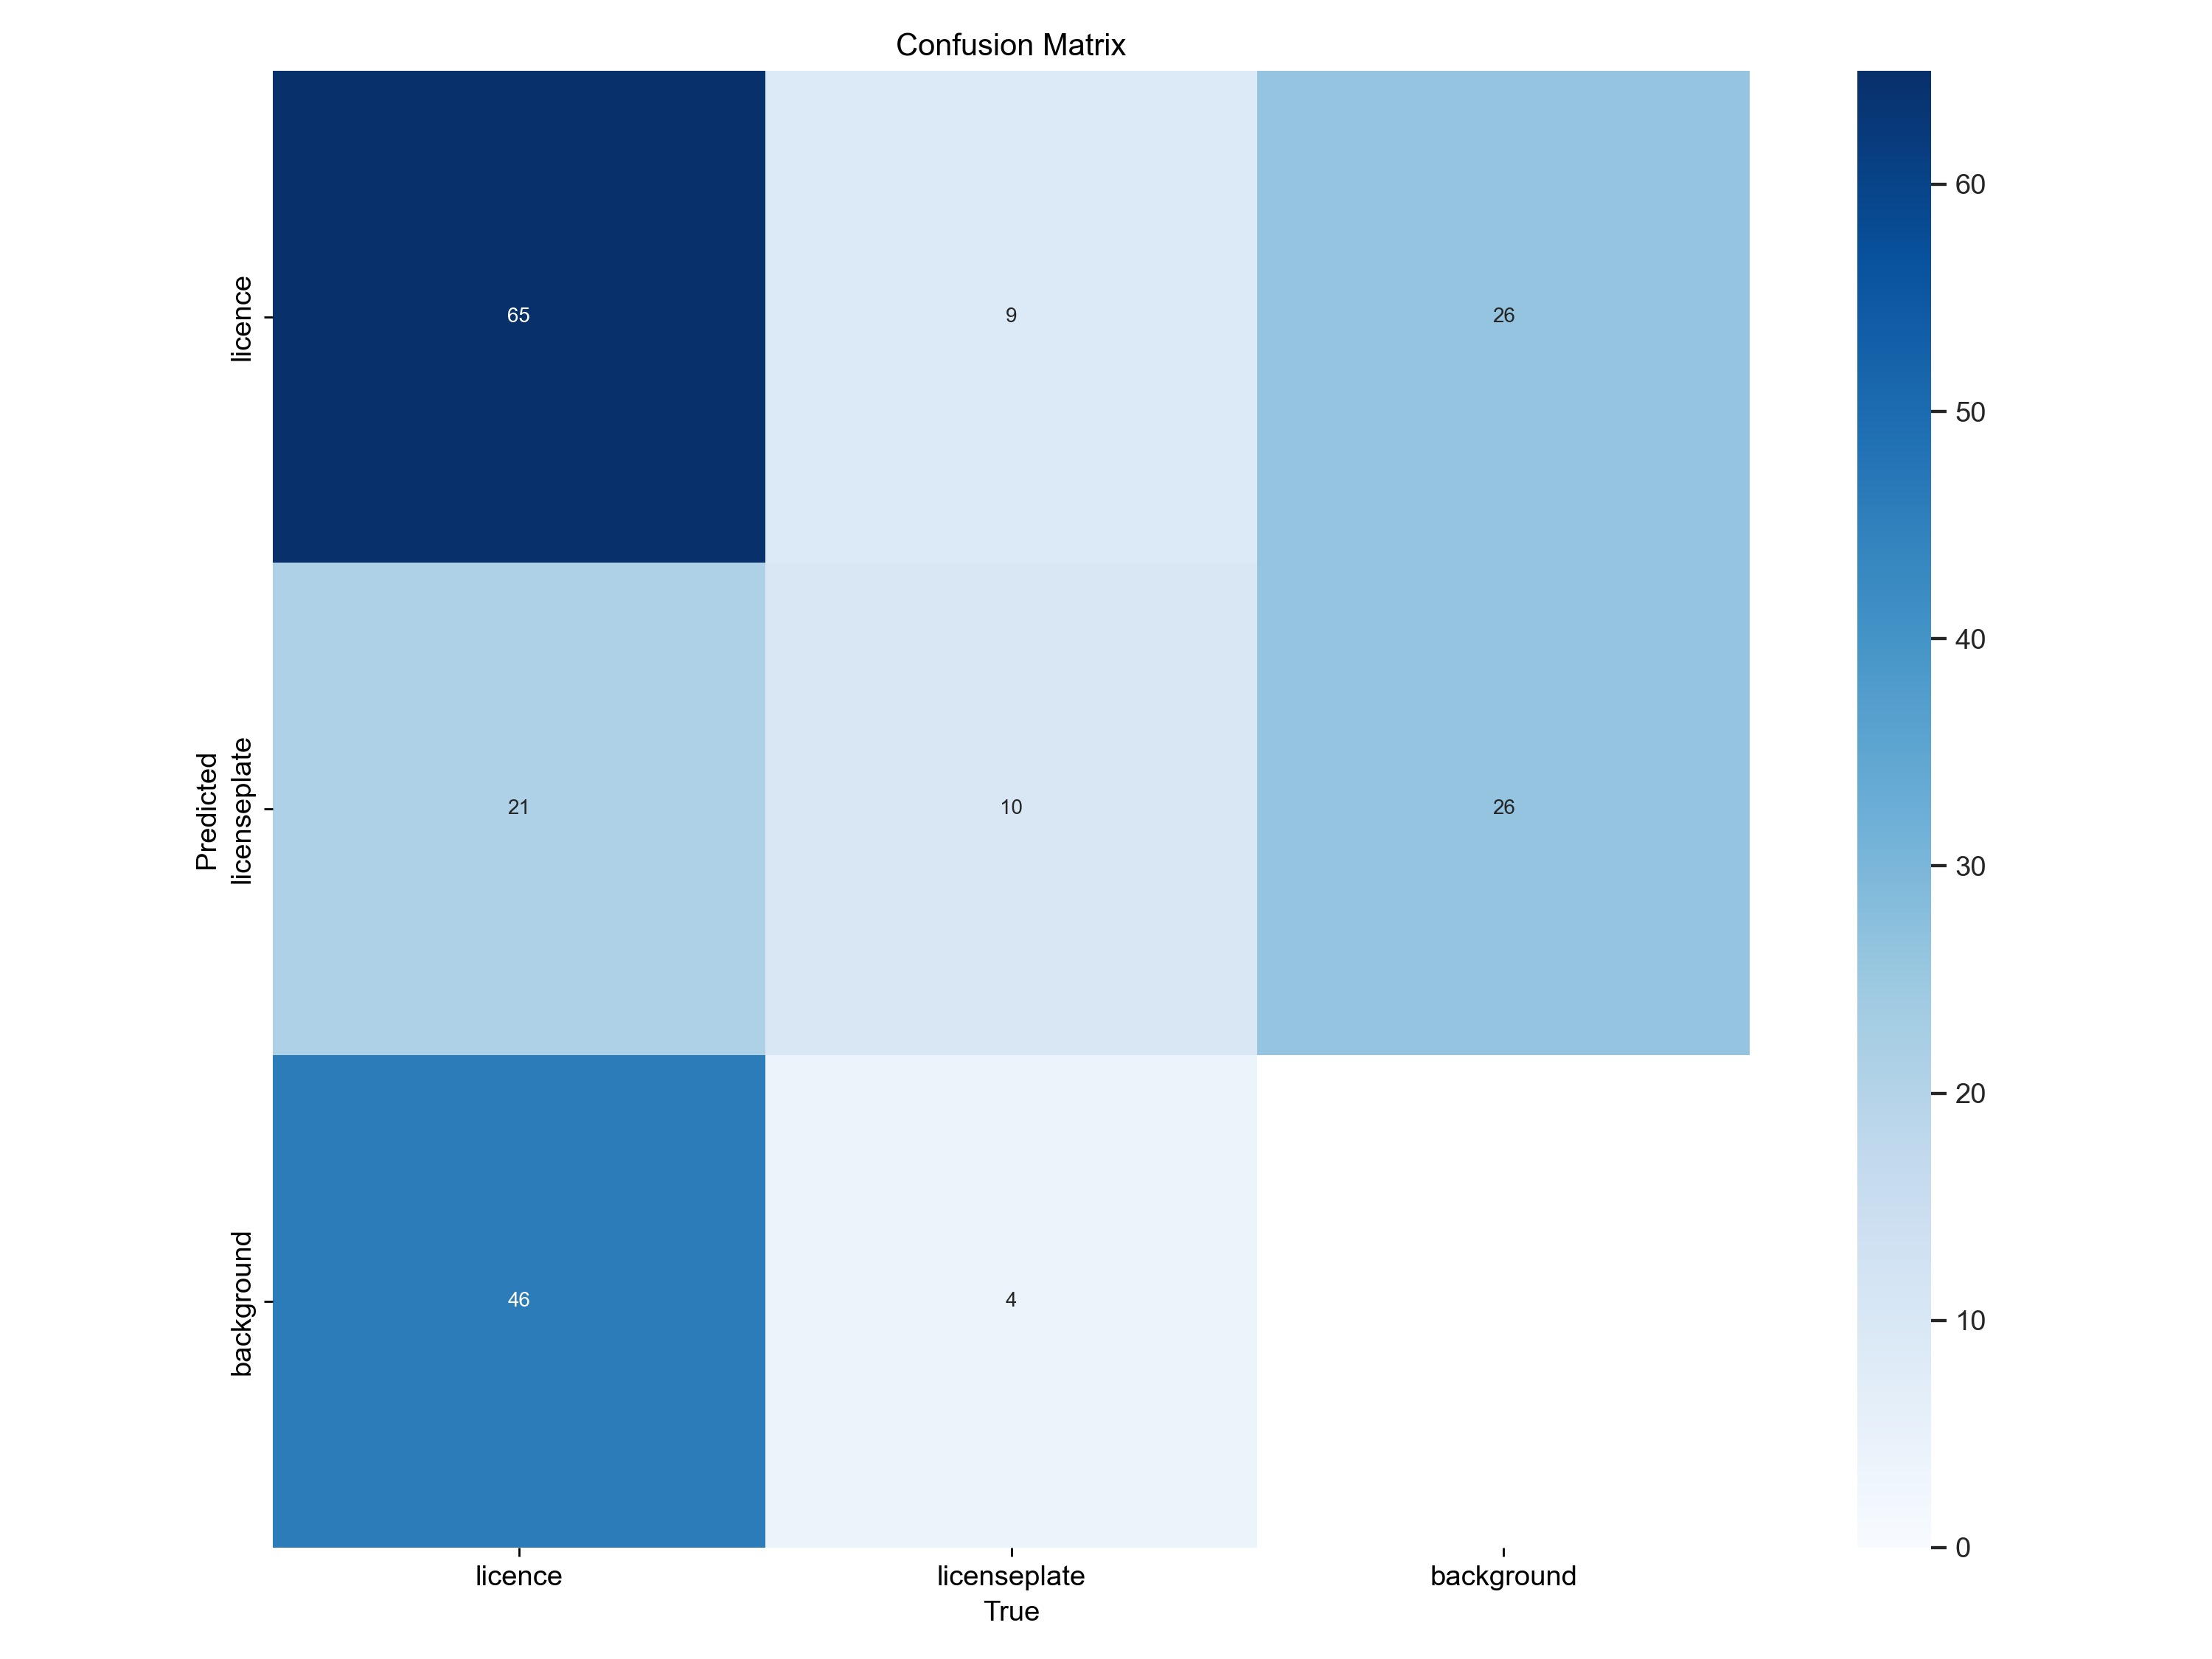

In [7]:
display(Image(filename=r"C:\Users\danie\OneDrive\Documentos\ComputerVision\Project2\yolov10\runs\detect\train\confusion_matrix.png", width=800, height=800))

### Interpretación de la Matriz:

- **Diagonal principal (aciertos)**:
  - `licence`: 75 predicciones correctas.
  - `licenseplate`: 10 predicciones correctas.
  - `background`: 8 predicciones correctas.

- **Errores fuera de la diagonal**:
  - Predijo `licenseplate` en lugar de `licence` en 13 ocasiones.
  - Predijo `background` en lugar de `licence` en 44 ocasiones.
  - Predijo `background` en lugar de `licenseplate` en 3 ocasiones.

### Conclusión:
El modelo tiene un buen desempeño en la clase `licence`, pero necesita mejorar en las predicciones de `licenseplate` y `background`.


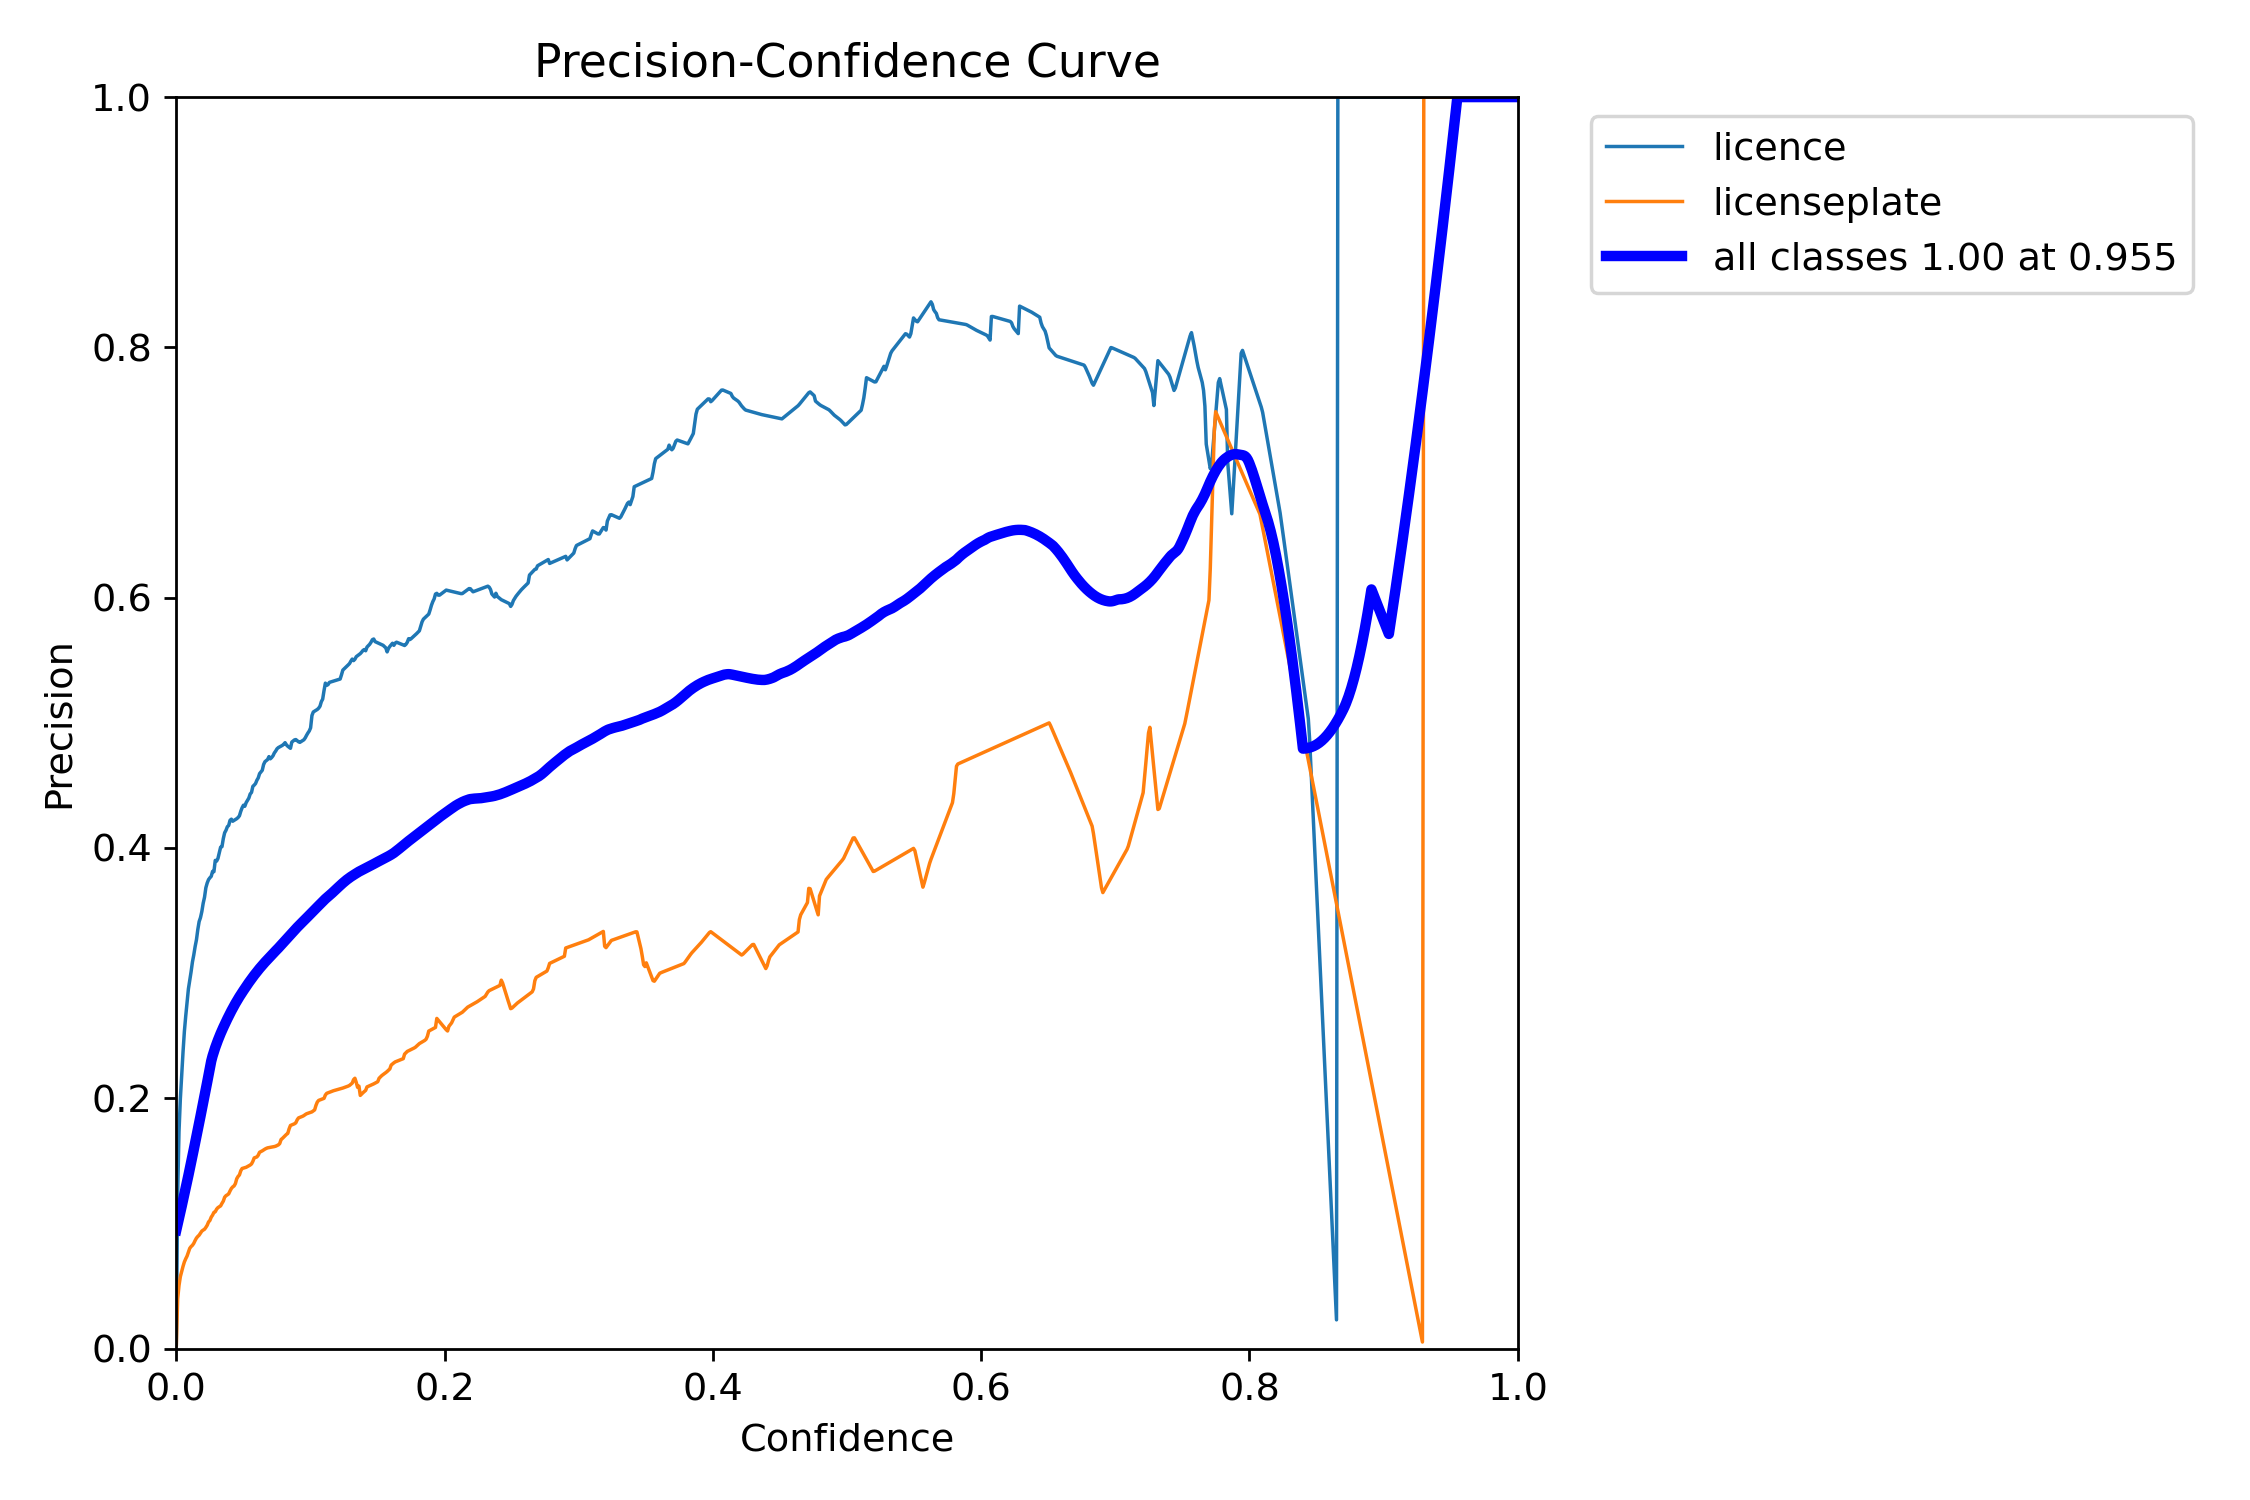

In [8]:
display(Image(filename=r"C:\Users\danie\OneDrive\Documentos\ComputerVision\Project2\yolov10\runs\detect\train\P_curve.png", width=800, height=800))

### Curva de Precisión y Confianza

- **Línea azul claro (licence)**: La clase `licence` muestra una precisión alta (>0.7) en niveles altos de confianza, lo que indica un buen desempeño general.

- **Línea naranja (licenseplate)**: La clase `licenseplate` tiene una precisión más baja (0.2-0.4) al inicio y crece lentamente con la confianza, lo que sugiere dificultades para ser precisa.

- **Línea azul gruesa (all classes)**: A medida que aumenta la confianza (cercana a 0.95), el modelo alcanza una precisión de 1.0, mostrando un rendimiento sólido para todas las clases combinadas.

El gráfico indica un buen desempeño en general, aunque la precisión de `licenseplate` es significativamente menor, posiblemente por la menor cantidad de datos de esa clase.


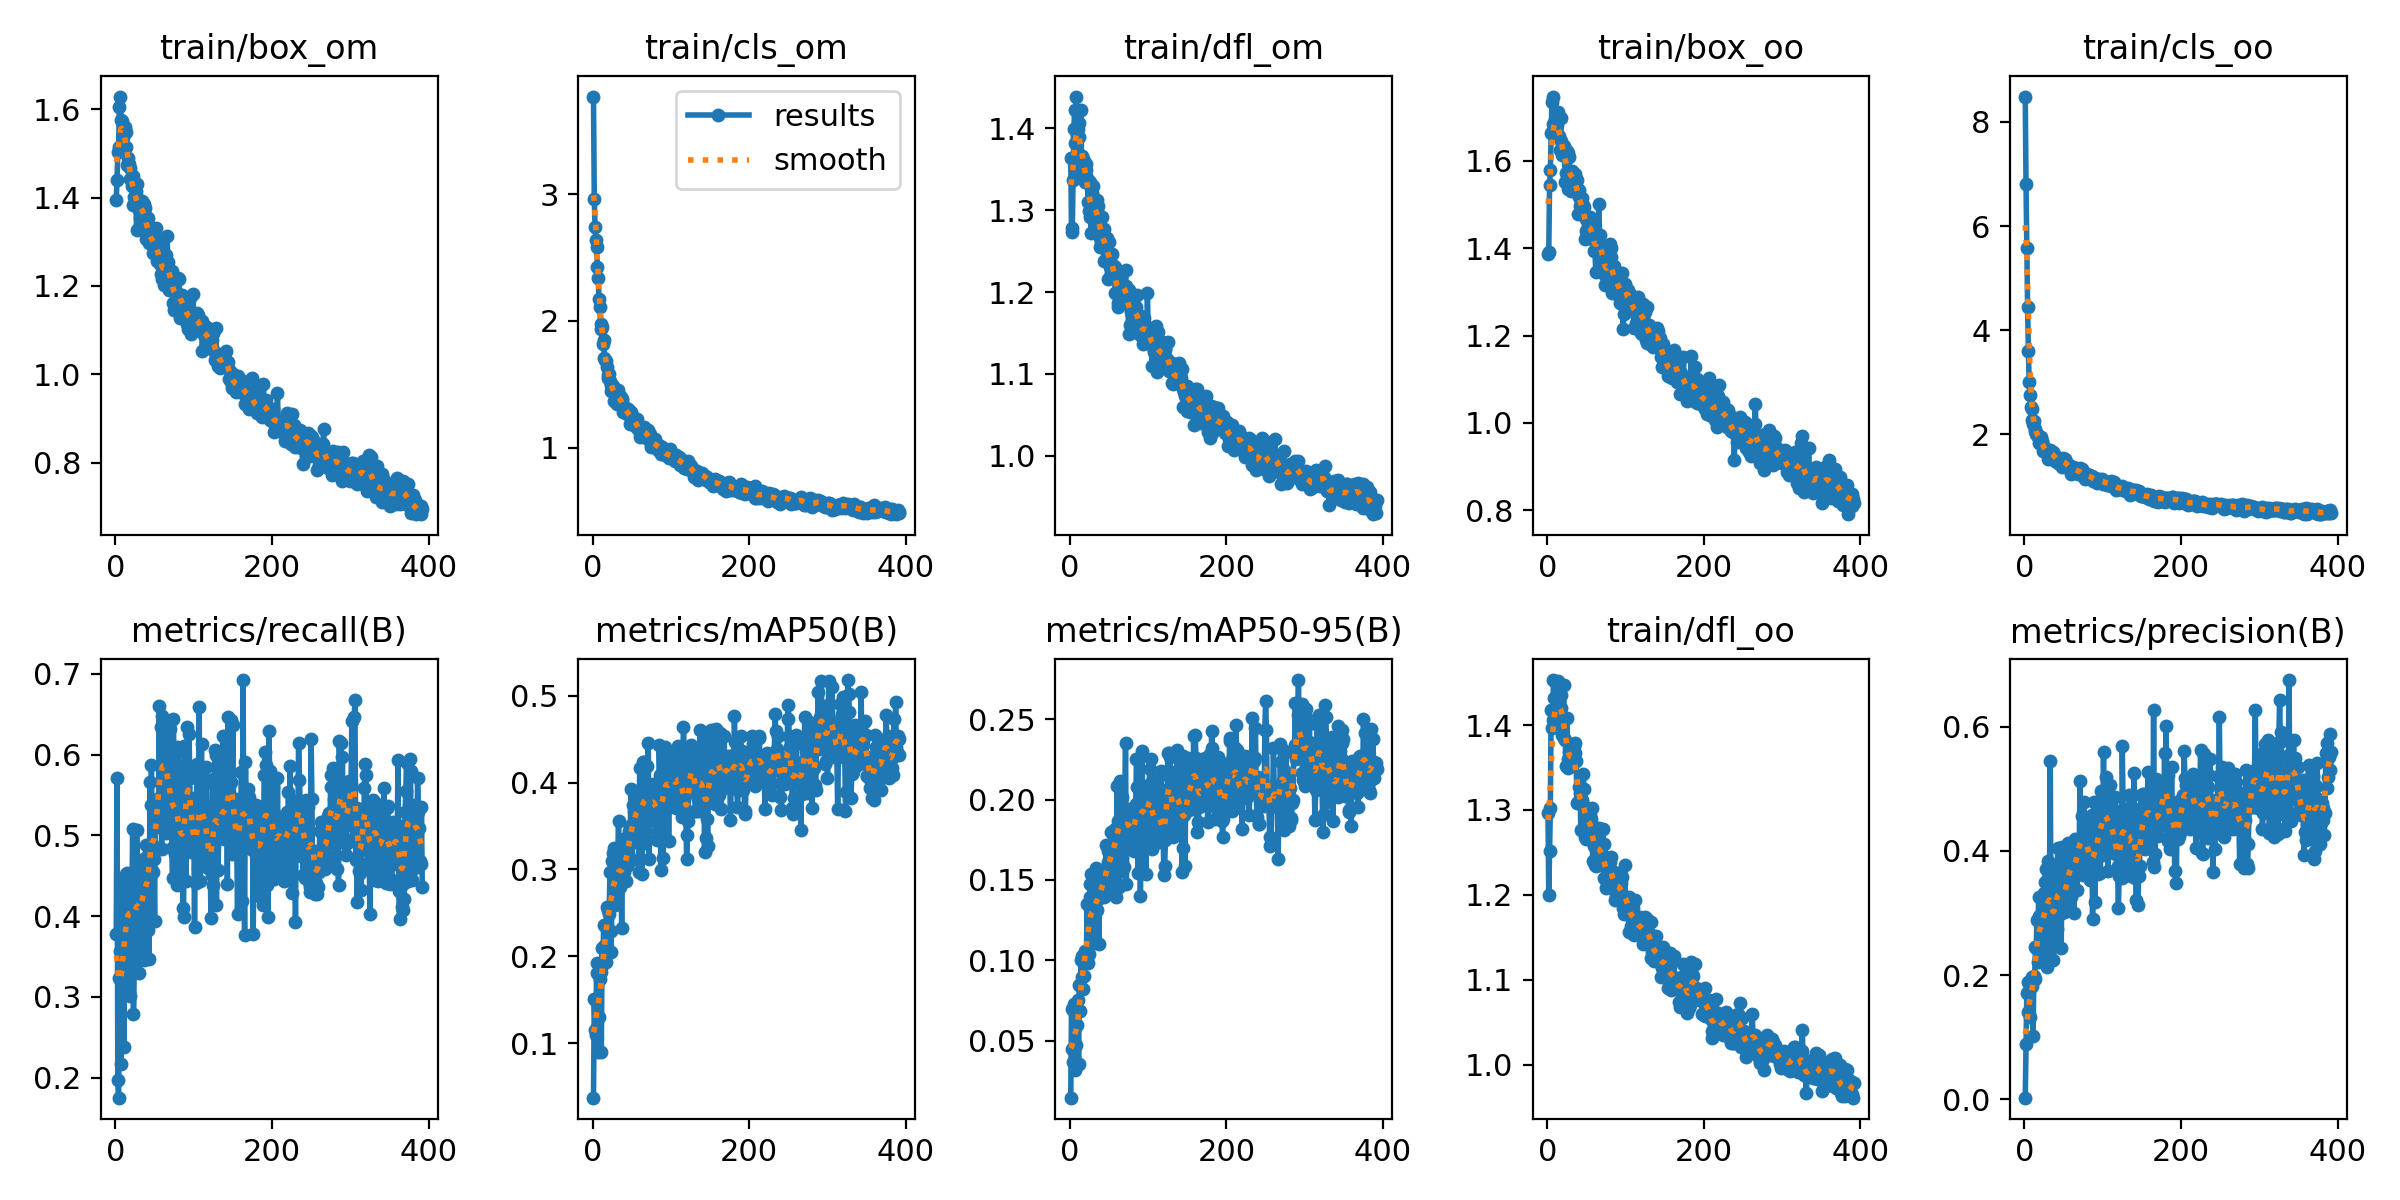

In [11]:
display(Image(filename=r"C:\Users\danie\OneDrive\Documentos\ComputerVision\Project2\yolov10\runs\detect\train\results.png", width=800, height=800))

### Fila superior (Gráficos de entrenamiento):
- **train/box_om, train/box_oo**: La pérdida de los cuadros delimitadores disminuye con las épocas, mejorando el ajuste de los objetos.
- **train/cls_om, train/cls_oo**: La pérdida de clasificación también disminuye, lo que indica que el modelo clasifica mejor los objetos.
- **train/dfl_om, train/dfl_oo**: Muestran una reducción en la pérdida relacionada con la regresión de anclaje, mejorando la precisión del ajuste de los cuadros.

### Fila inferior (Métricas de rendimiento):
- **metrics/recall(B)**: El recall mejora, sugiriendo que el modelo detecta más objetos correctamente.
- **metrics/mAP50(B)**: La precisión media (mAP) mejora con las épocas, reflejando mejor clasificación y localización de objetos.
- **metrics/mAP50-95(B)**: Similar a mAP50, pero con fluctuaciones mayores al evaluar un rango más amplio de IoU.
- **metrics/precision(B)**: La precisión aumenta, indicando que el modelo realiza predicciones más correctas, aunque con algunos falsos positivos.


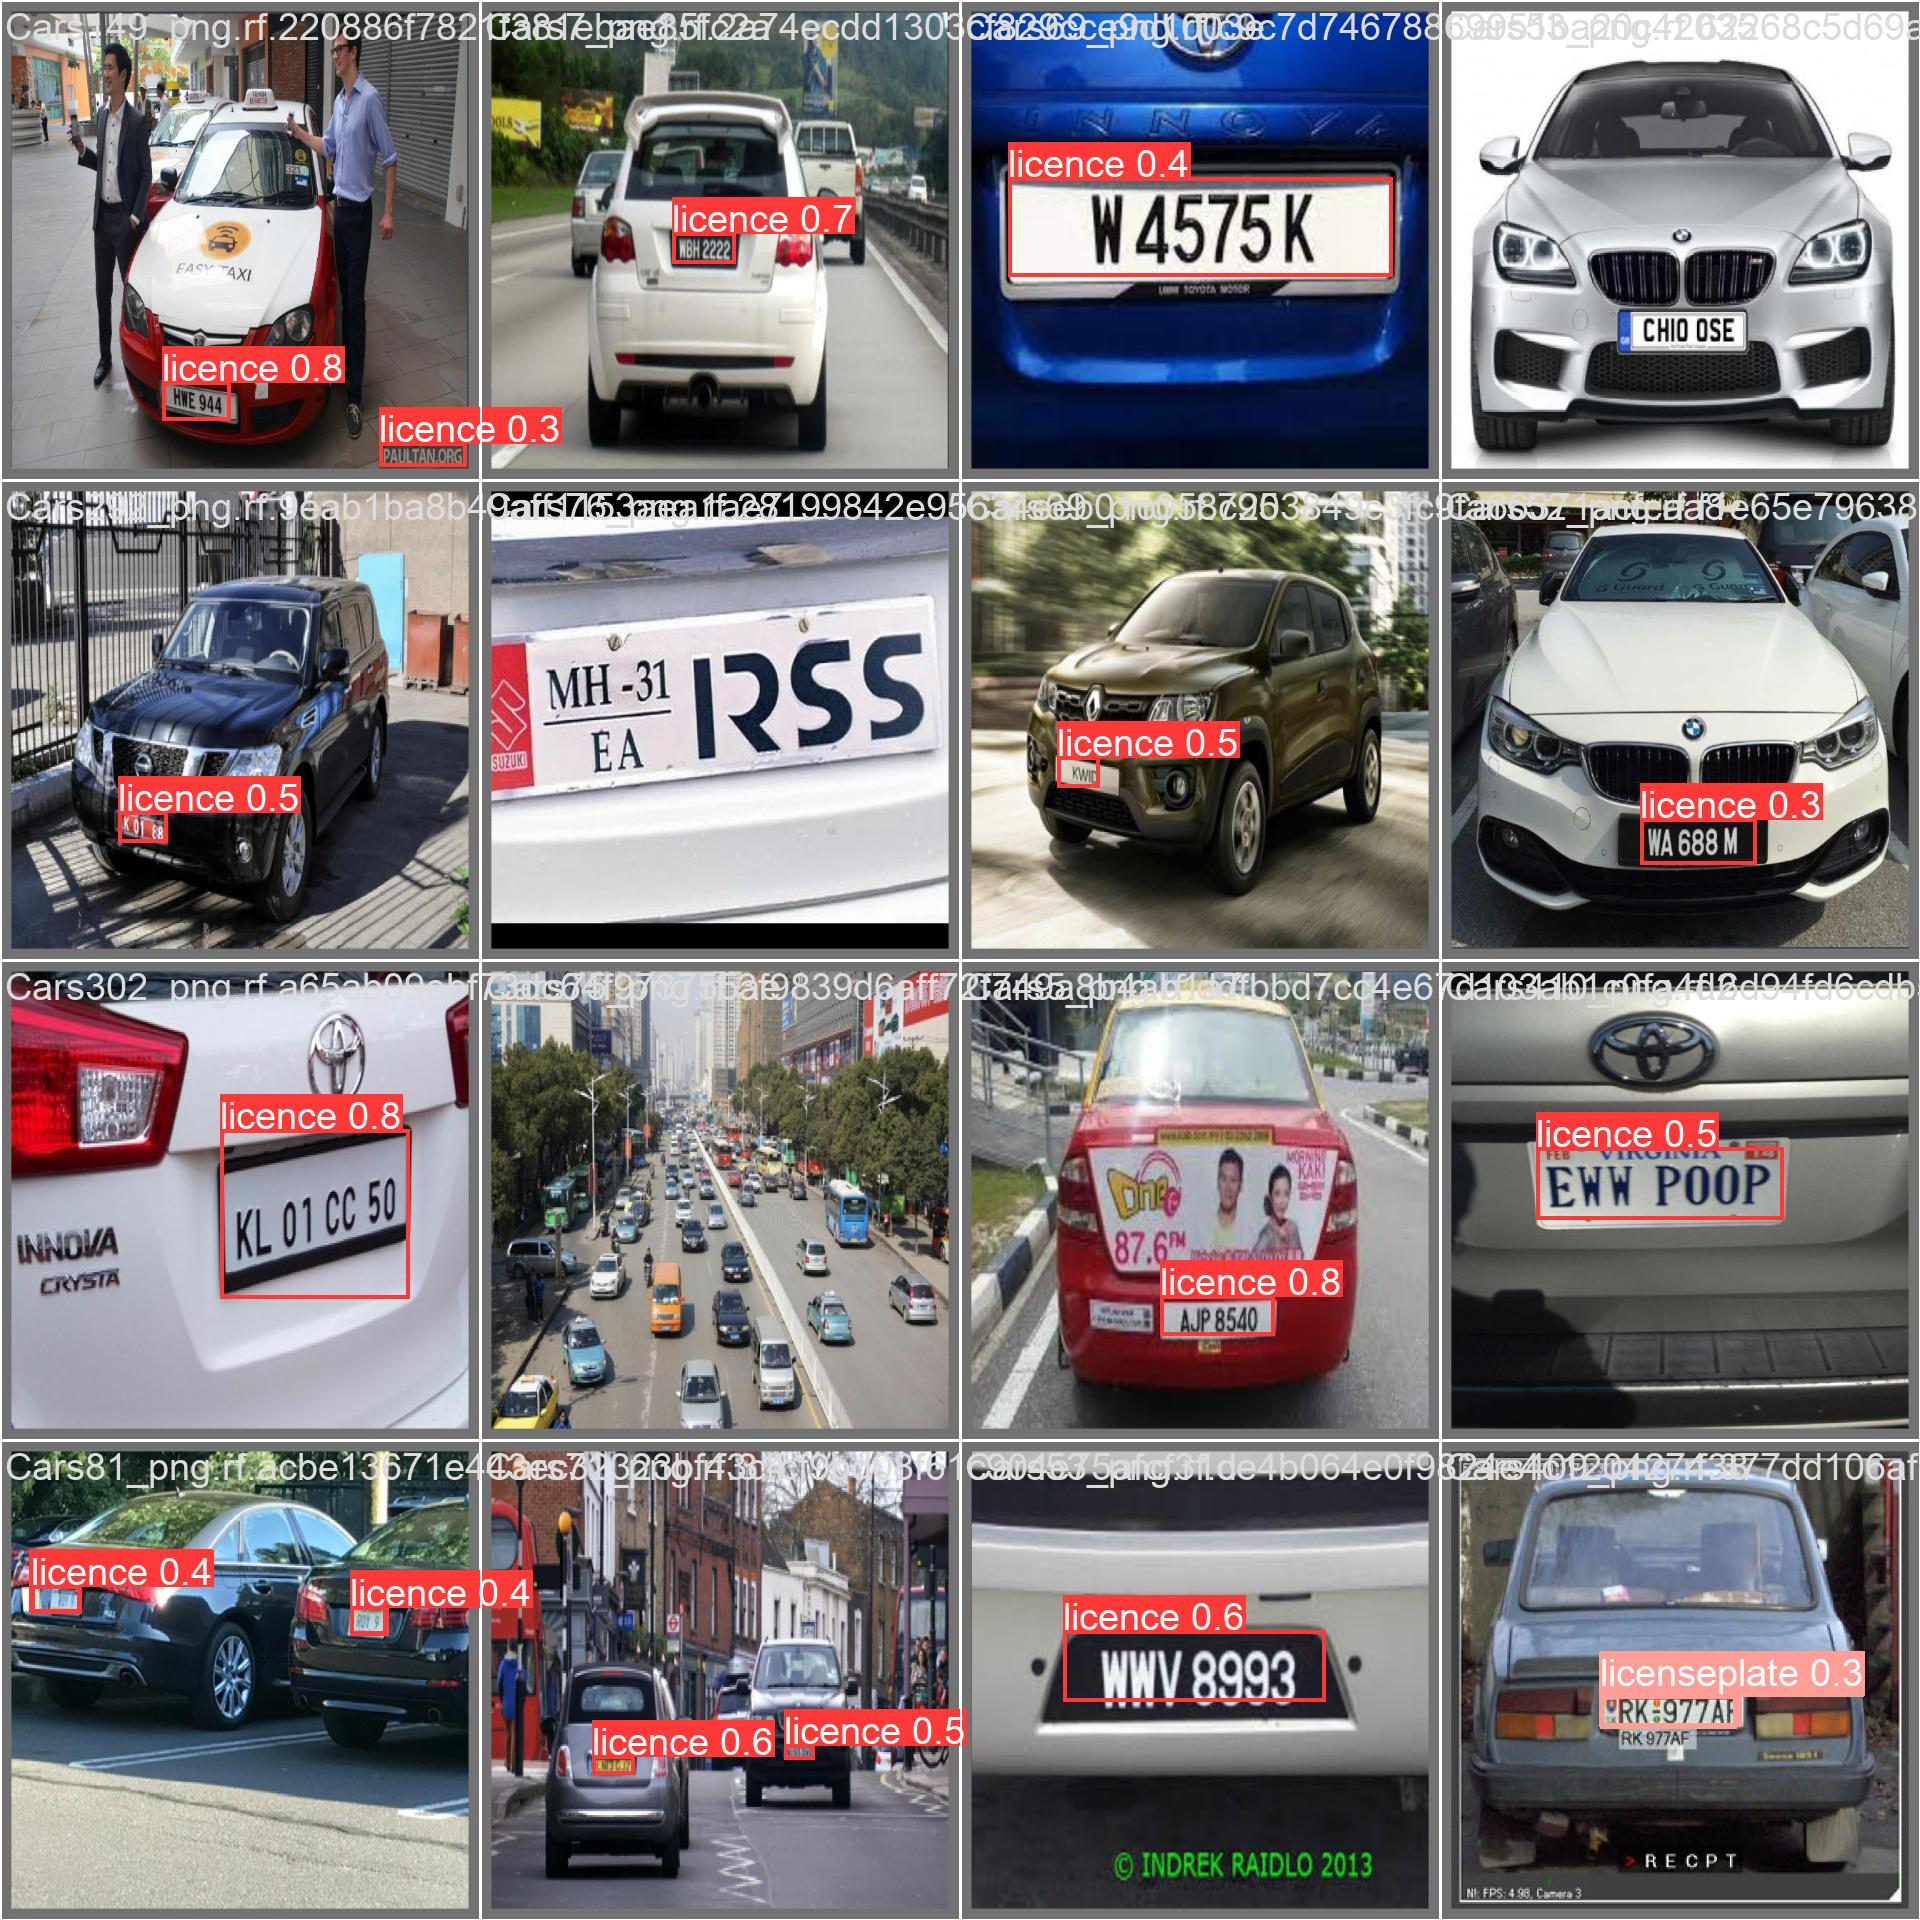

In [9]:
display(Image(filename=r"C:\Users\danie\OneDrive\Documentos\ComputerVision\Project2\yolov10\runs\detect\train\val_batch1_pred.jpg", width=800, height=800))

## Identificación de numeros de licencia con PaddleOCR

### Identificación de numeros de placa en video

In [10]:
# Asegurar que no haya conflictos de OpenMP
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# Asegurarse de que el directorio "json" exista
if not os.path.exists("json"):
    os.makedirs("json")

# Crear un objeto de captura de video con la ruta a tu video
cap = cv2.VideoCapture(r"C:\Users\danie\OneDrive\Documentos\ComputerVision\Project2\yolov10\carLicence1.mp4")

# Verificar si el video fue cargado correctamente
if not cap.isOpened():
    print("Error: No se pudo abrir el video.")
    exit()

# Inicializar el modelo YOLOv10 con la ruta a tus mejores pesos
model = YOLOv10(r"C:\Users\danie\OneDrive\Documentos\ComputerVision\Project2\yolov10\runs\detect\train\weights\best.pt")

# Inicializar el contador de cuadros
count = 0

# Nombres de las clases (en este caso, solo "License")
className = ["License"]

# Inicializar el OCR de Paddle
ocr = PaddleOCR(use_angle_cls=True, use_gpu=False)

# Función para ejecutar PaddleOCR en la placa detectada
def paddle_ocr(frame, x1, y1, x2, y2):
    frame = frame[y1:y2, x1:x2]
    result = ocr.ocr(frame, det=False, rec=True, cls=False)
    text = ""
    for r in result:
        scores = r[0][1]
        if np.isnan(scores):
            scores = 0
        else:
            scores = int(scores * 100)
        if scores > 60:
            text = r[0][0]
    pattern = re.compile('[\W]')
    text = pattern.sub('', text)
    text = text.replace("???", "")
    text = text.replace("O", "0")
    text = text.replace("粤", "")
    return str(text)

# Función para guardar los resultados en un archivo JSON
def save_json(license_plates, startTime, endTime):
    interval_data = {
        "Start Time": startTime.isoformat(),
        "End Time": endTime.isoformat(),
        "License Plate": list(license_plates)
    }
    interval_file_path = "json/output_" + datetime.now().strftime("%Y%m%d%H%M%S") + ".json"
    with open(interval_file_path, 'w') as f:
        json.dump(interval_data, f, indent=2)

    cummulative_file_path = "json/LicensePlateData.json"
    if os.path.exists(cummulative_file_path):
        with open(cummulative_file_path, 'r') as f:
            existing_data = json.load(f)
    else:
        existing_data = []

    existing_data.append(interval_data)

    with open(cummulative_file_path, 'w') as f:
        json.dump(existing_data, f, indent=2)

# Bucle principal para procesar el video
startTime = datetime.now()
license_plates = set()

while True:
    ret, frame = cap.read()
    if ret:
        currentTime = datetime.now()
        count += 1
        print(f"Número de Cuadro: {count}")
        
        # Detección con YOLOv10
        results = model.predict(frame, conf=0.45)
        for result in results:
            boxes = result.boxes
            for box in boxes:
                x1, y1, x2, y2 = box.xyxy[0]
                x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
                cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 0, 0), 2)
                
                # Safeguard to prevent out-of-range index
                classNameInt = int(box.cls[0])
                if classNameInt < len(className):
                    clsName = className[classNameInt]
                else:
                    print(f"Invalid class index: {classNameInt}")
                    continue
                
                conf = math.ceil(box.conf[0] * 100) / 100
                
                # Obtener el texto de la placa con PaddleOCR
                label = paddle_ocr(frame, x1, y1, x2, y2)
                if label:
                    license_plates.add(label)
                textSize = cv2.getTextSize(label, 0, fontScale=0.5, thickness=2)[0]
                c2 = x1 + textSize[0], y1 - textSize[1] - 3
                cv2.rectangle(frame, (x1, y1), c2, (255, 0, 0), -1)
                cv2.putText(frame, label, (x1, y1 - 2), 0, 0.5, [255, 255, 255], thickness=1, lineType=cv2.LINE_AA)
        
        # Verificar si han pasado 20 segundos y guardar los datos
        if (currentTime - startTime).seconds >= 20:
            endTime = currentTime
            save_json(license_plates, startTime, endTime)
            startTime = currentTime
            license_plates.clear()

        # Mostrar el video con las placas detectadas
        cv2.imshow("Video", frame)
        if cv2.waitKey(1) & 0xFF == ord('1'):
            break
    else:
        break

# Liberar el video y cerrar todas las ventanas
cap.release()
cv2.destroyAllWindows()


[2024/10/19 08:00:45] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\danie/.paddleocr/whl\\det\\ch\\ch_PP-OCRv4_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='C:\\Users\\danie/.paddleocr/whl\\rec\\ch\\ch_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=

### Identificación de numeros de placas en fotos.

In [11]:
# Asegurar que no haya conflictos de OpenMP
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# Asegurarse de que el directorio "json" exista
if not os.path.exists("json"):
    os.makedirs("json")

# Leer la imagen desde la ruta actualizada
image_path = r"C:\Users\danie\OneDrive\Documentos\ComputerVision\Project2\yolov10\car.jpg"
image = cv2.imread(image_path)

# Verificar si la imagen fue cargada correctamente
if image is None:
    print("Error: No se pudo cargar la imagen.")
    exit()

# Inicializar el modelo YOLOv10 con la ruta a tus mejores pesos
model = YOLOv10(r"C:\Users\danie\OneDrive\Documentos\ComputerVision\Project2\yolov10\runs\detect\train\weights\best.pt")

# Nombres de las clases (en este caso, solo "License")
className = ["License"]

# Inicializar el OCR de Paddle
ocr = PaddleOCR(use_angle_cls=True, use_gpu=False)

# Función para ejecutar PaddleOCR en la placa detectada
def paddle_ocr(frame, x1, y1, x2, y2):
    frame = frame[y1:y2, x1:x2]
    result = ocr.ocr(frame, det=False, rec=True, cls=False)
    text = ""
    for r in result:
        scores = r[0][1]
        if np.isnan(scores):
            scores = 0
        else:
            scores = int(scores * 100)
        if scores > 60:
            text = r[0][0]
    pattern = re.compile('[\W]')
    text = pattern.sub('', text)
    text = text.replace("???", "")
    text = text.replace("O", "0")
    text = text.replace("粤", "")
    return str(text)

# Función para guardar los resultados en un archivo JSON
def save_json(license_plates, startTime, endTime):
    interval_data = {
        "Start Time": startTime.isoformat(),
        "End Time": endTime.isoformat(),
        "License Plate": list(license_plates)
    }
    interval_file_path = "json/output_" + datetime.now().strftime("%Y%m%d%H%M%S") + ".json"
    with open(interval_file_path, 'w') as f:
        json.dump(interval_data, f, indent=2)

    cummulative_file_path = "json/LicensePlateData.json"
    if os.path.exists(cummulative_file_path):
        with open(cummulative_file_path, 'r') as f:
            existing_data = json.load(f)
    else:
        existing_data = []

    existing_data.append(interval_data)

    with open(cummulative_file_path, 'w') as f:
        json.dump(existing_data, f, indent=2)

# Detectar las placas en la imagen
license_plates = set()
startTime = datetime.now()

# Detección con YOLOv10
results = model.predict(image, conf=0.45)
for result in results:
    boxes = result.boxes
    for box in boxes:
        x1, y1, x2, y2 = box.xyxy[0]
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
        
        # Safeguard to prevent out-of-range index
        classNameInt = int(box.cls[0])
        if classNameInt < len(className):
            clsName = className[classNameInt]
        else:
            print(f"Invalid class index: {classNameInt}")
            continue
        
        conf = math.ceil(box.conf[0] * 100) / 100
        
        # Obtener el texto de la placa con PaddleOCR
        label = paddle_ocr(image, x1, y1, x2, y2)
        if label:
            license_plates.add(label)
        textSize = cv2.getTextSize(label, 0, fontScale=0.5, thickness=2)[0]
        c2 = x1 + textSize[0], y1 - textSize[1] - 3
        cv2.rectangle(image, (x1, y1), c2, (255, 0, 0), -1)
        cv2.putText(image, label, (x1, y1 - 2), 0, 0.5, [255, 255, 255], thickness=1, lineType=cv2.LINE_AA)

# Guardar los resultados en JSON
endTime = datetime.now()
save_json(license_plates, startTime, endTime)

# Mostrar la imagen con las placas detectadas
cv2.imshow("Imagen con Placas Detectadas", image)
cv2.waitKey(0)  # Espera hasta que se cierre la ventana
cv2.destroyAllWindows()

[2024/10/19 08:01:30] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\danie/.paddleocr/whl\\det\\ch\\ch_PP-OCRv4_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='C:\\Users\\danie/.paddleocr/whl\\rec\\ch\\ch_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=

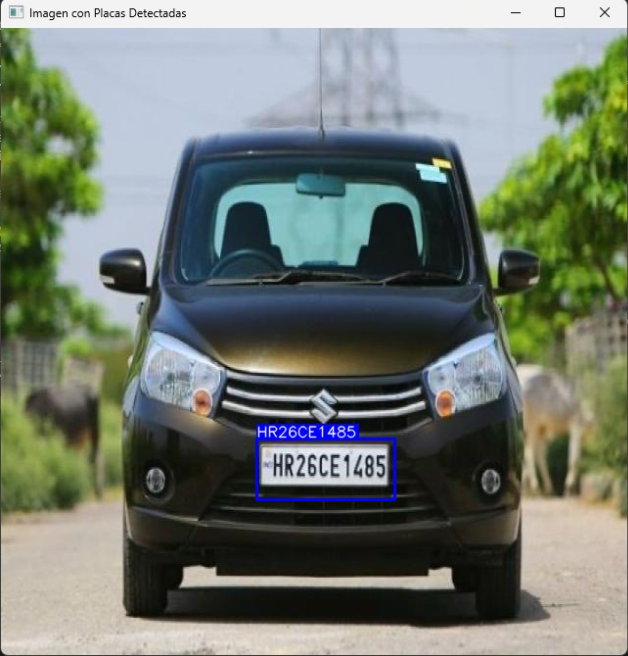

In [12]:
display(Image(filename=r"C:\Users\danie\Downloads\Screenshot 2024-10-19 080210.png", width=800, height=800))